# Experiments done on the Deutsch Jozsa Algorithm (DJA)

In [1]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors

from qiskit import QuantumCircuit, transpile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Code to create the quantum circuit for DJA (taken from [**IBM Quantum Learning**](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms))

In [2]:
def dj_function(num_qubits, balanced=True):
    qc = QuantumCircuit(num_qubits + 1)
    
    if np.random.randint(0, 2):
        qc.x(num_qubits)  # Flip output qubit with 50% chance

    if balanced:
        # Create a balanced function
        # Choose half the possible input states
        on_states = np.random.choice(
            range(2**num_qubits),  # numbers to sample from
            2**num_qubits // 2,  # number of samples
            replace=False,  # makes sure states are only sampled once
        )

        def add_cx(qc, bit_string):
            for qubit, bit in enumerate(reversed(bit_string)):
                if bit == "1":
                    qc.x(qubit)
            return qc

        for state in on_states:
            qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
            qc = add_cx(qc, f"{state:0b}")
            qc.mcx(list(range(num_qubits)), num_qubits)
            qc = add_cx(qc, f"{state:0b}")

    qc.barrier()
    return qc


In [3]:
def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    # qc.x(n)  # bug
    qc.x(n)      #1
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)   #2
    qc.h(range(n))        #3
    # qc.x(0)  # bug
    qc.measure(range(n), range(n))
    return qc

In [4]:
def dj_algorithm(function: QuantumCircuit, noise, shots):
    qc = compile_circuit(function)
    simulator = AerSimulator(noise_model=noise)
    qc = qc.decompose(reps=10)
    # qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots, memory=True).result()
    # measurements = result.get_memory()
    return result.get_counts(), qc

### Function to calculate Bias and Entropy

In [5]:
from math import log2

def calculate_bias_entropy(output_map, unwanted_states):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key in unwanted_states:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy

### Configurations

In [6]:
def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')

In [7]:
n=3
unwanted_cons = [to_bin(i,n) for i in range(1, pow(2,n))]
unwanted_bal = [to_bin(0,n)]
unwanted = {'balanced': unwanted_bal,
            'constant': unwanted_cons}
shots=10000
runs=10000

In [8]:
def empty_dict():
    dict = {}
    keys = unwanted_cons+unwanted_bal
    dict = dict.fromkeys(keys, 0)
    return dict

### Custom noise model

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def create_noise_model_final(p):
    noise_model = NoiseModel()

    # 1-qubit depolarizing channel
    error_1q = depolarizing_error(4*p/3, 1)
    noise_model.add_all_qubit_quantum_error(error_1q, ['id', 'u', 'u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])

    # 2-qubit depolarizing channel
    error_2q = depolarizing_error(16*p/15, 2)
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    return noise_model


# with Balanced Functions

#### Threshold calculation

In [24]:
num_ops_bal = []
for _ in range(runs):
    f = dj_function(n, balanced=1)
    qc = compile_circuit(f)
    qc = qc.decompose(reps=10)
    ops = qc.count_ops()
    count=0
    for key,val in ops.items():
        if key!='barrier' and key!='measure':
            count+=val
    num_ops_bal.append(count)

num_ops_bal = np.array(num_ops_bal)
num_gates_bal = num_ops_bal.mean()
print("Average number of gate operations:", num_gates_bal)
expected_thresh_bal = (1 - (2**n - len(unwanted['balanced']))/2**n)/num_gates_bal
print('Expected Threshold: ', expected_thresh_bal)

Average number of gate operations: 144.4677
Expected Threshold:  0.0008652453108895621


#### Noise models

In [25]:
noise_bal = {'no' : None,
        'below_thresh' : create_noise_model_final(expected_thresh_bal/2),
             'thresh' : create_noise_model_final(expected_thresh_bal)}

## Count Histograms

#### Without Noise

In [26]:
dist_bal_nonoise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm(f, noise_bal['no'], shots)
    for key, val in result.items():
        dist_bal_nonoise[key] += val

arr_bal_nonoise = calculate_bias_entropy(dist_bal_nonoise, unwanted['balanced'])
print("Bias: ", arr_bal_nonoise[0], " Entropy: ",arr_bal_nonoise[1])
for key, val in dist_bal_nonoise.items():
    dist_bal_nonoise[key] = val/(shots*runs)

Bias:  0.0  Entropy:  2.807233314136737


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\3682713552.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_nonoise.show()


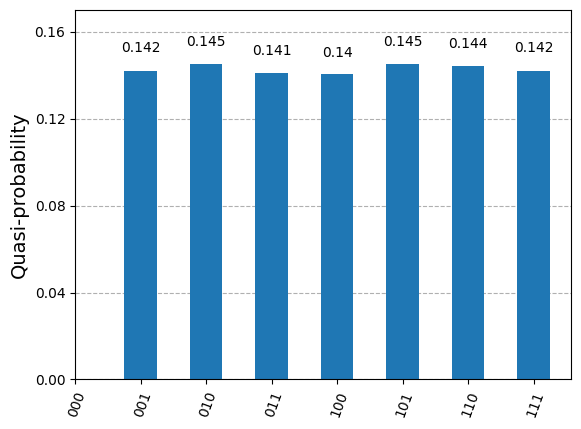

In [62]:
%matplotlib inline
# fig_bal_nonoise = plot_histogram(dist_bal_nonoise, title=f"Noise-Free\nBias={arr_bal_nonoise[0]:.4f}, Entropy={arr_bal_nonoise[1]:.4f}")
fig_bal_nonoise = plot_histogram(dist_bal_nonoise)

# # Set the y-axis range to go up to 1
ax = fig_bal_nonoise.gca()  # Get the current axes
ax.set_ylim(0, 0.17)  # Set y-axis limits

# Show the modified plot
fig_bal_nonoise.show()

#### With Noise below threshold

In [28]:
dist_bal_low_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm(f, noise_bal['below_thresh'], shots)
    for key, val in result.items():
        dist_bal_low_noise[key] += val

arr_bal_low_noise = calculate_bias_entropy(dist_bal_low_noise, unwanted['balanced'])
print(f"Bias : {arr_bal_low_noise[0]}, Entropy : {arr_bal_low_noise[1]}")
for key, val in dist_bal_low_noise.items():
    dist_bal_low_noise[key] = val/(shots*runs)

Bias : 0.00966323, Entropy : 2.858608929889515


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\3479881986.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_low_noise.show()


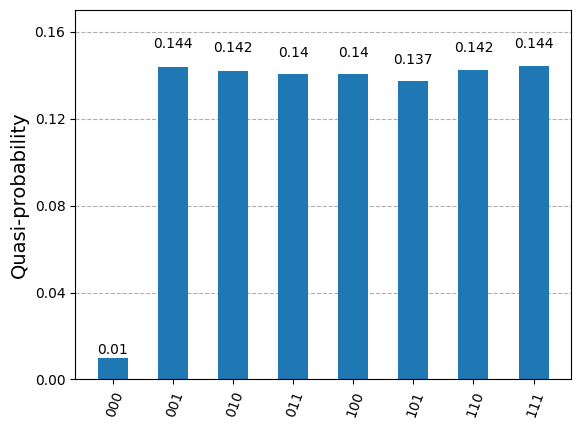

In [63]:
# fig_bal_low_noise = plot_histogram(dist_bal_low_noise, title=f"Noise below Threshold\nBias={arr_bal_low_noise[0]:.4f}, Entropy={arr_bal_low_noise[1]:.4f}")
fig_bal_low_noise = plot_histogram(dist_bal_low_noise)

# Set the y-axis range to go up to 1
ax = fig_bal_low_noise.gca()  # Get the current axes
ax.set_ylim(0, 0.17)  # Set y-axis limits

# Show the modified plot
fig_bal_low_noise.show()

#### With Noise at Threshold

In [30]:
dist_bal_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm(f, noise_bal['thresh'], shots)
    for key, val in result.items():
        dist_bal_noise[key] += val

arr_bal_noise = calculate_bias_entropy(dist_bal_noise, unwanted['balanced'])
print(f"Bias : {arr_bal_noise[0]}, Entropy : {arr_bal_noise[1]}")
for key, val in dist_bal_noise.items():
    dist_bal_noise[key] = val/(shots*runs)

Bias : 0.01865695, Entropy : 2.888696006359465


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\1732922869.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_noise.show()


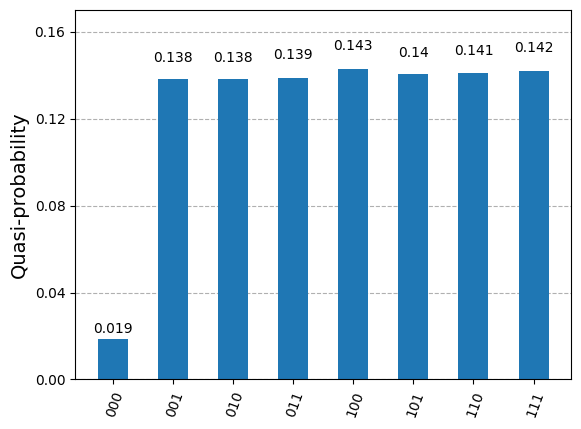

In [64]:
# fig_bal_noise = plot_histogram(dist_bal_noise, title=f"Noise at Threshold\nBias={arr_bal_noise[0]:.4f}, Entropy={arr_bal_noise[1]:.4f}")
fig_bal_noise = plot_histogram(dist_bal_noise)

# Set the y-axis range to go up to 1
ax = fig_bal_noise.gca()  # Get the current axes
ax.set_ylim(0, 0.17)  # Set y-axis limits

# Show the modified plot
fig_bal_noise.show()

### Entropy vs Noise

In [18]:
runs = 1000
entropies_bal = []
biases_bal = []
noise_levels_bal = [j/10000.0 for j in range(0, 101, 2)]
for i in tqdm(noise_levels_bal, desc="Processing Noise Levels"):
    dist_bal_evn = empty_dict()
    noise_model = create_noise_model_final(i)
    for _ in range(runs):
        f = dj_function(n, balanced=1)  #bal
        result = dj_algorithm(f, noise_model, shots)[0]
        for key, val in result.items():
            dist_bal_evn[key] += val
    arr_bal_evn = calculate_bias_entropy(dist_bal_evn, unwanted['balanced'])
    biases_bal.append(arr_bal_evn[0])
    entropies_bal.append(arr_bal_evn[1])
runs = 10000

Processing Noise Levels: 100%|██████████| 51/51 [1:20:30<00:00, 94.73s/it] 


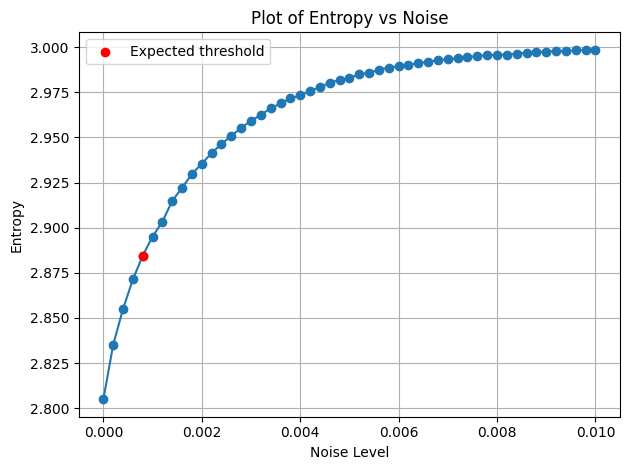

In [ ]:
# Plot the data
plt.plot(noise_levels_bal, entropies_bal, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Entropy')
plt.title('Plot of Entropy vs Noise')

# Target noise level and entropy value
# noise_level_target = round(expected_thresh_bal, 4)
noise_level_target = 0.0008
entropy_value = entropies_bal[noise_levels_bal.index(noise_level_target)]  # Find corresponding entropy value
plt.scatter([noise_level_target], [entropy_value], color='red', zorder=2, label=f'at Expected threshold')
# plt.text(noise_level_target + 0.0002, entropy_value-0.001, f'({noise_level_target:.4f}, {entropy_value:.4f})', 
        #  color='black', fontsize=10)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# with Constant Functions

#### Threshold calculation

In [12]:
num_ops_cons = []
for _ in range(runs):
    f = dj_function(n, balanced=0)
    qc = compile_circuit(f)
    qc = qc.decompose(reps=10)
    ops = qc.count_ops()
    count=0
    for key,val in ops.items():
        if key!='barrier' and key!='measure':
            count+=val
    num_ops_cons.append(count)

num_ops_cons = np.array(num_ops_cons)
num_gates_cons = num_ops_cons.mean()
print("Average number of gate operations:", num_gates_cons)
expected_thresh_cons = (1 - (2**n - len(unwanted['constant']))/2**n)/num_gates_cons
print('Expected Threshold: ', expected_thresh_cons)

Average number of gate operations: 8.5065
Expected Threshold:  0.10286251689884206


#### Noise models

In [13]:
noise_cons = {'no' : None,
              'below_thresh' : create_noise_model_final(expected_thresh_cons/2),
              'thresh' : create_noise_model_final(expected_thresh_cons)}

## Count Histograms

#### Without Noise

In [14]:
dist_cons_nonoise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm(f, noise_cons['no'], shots)
    for key, val in result.items():
        dist_cons_nonoise[key] += val

arr_cons_nonoise = calculate_bias_entropy(dist_cons_nonoise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_nonoise[0]}, Entropy : {arr_cons_nonoise[1]}")
for key, val in dist_cons_nonoise.items():
    dist_cons_nonoise[key] = val/(shots*runs)


Bias : 0.0, Entropy : 0.0


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\2609032112.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_nonoise.show()


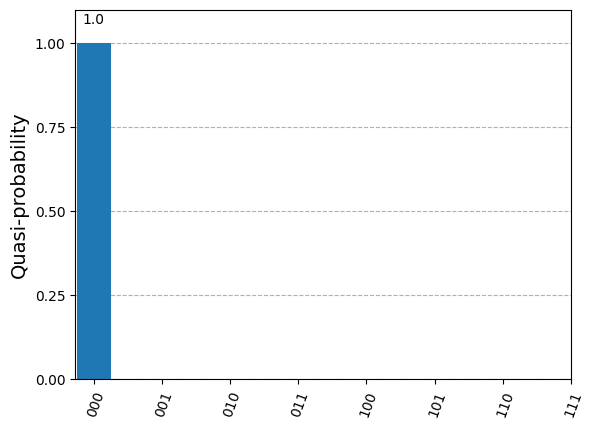

In [65]:
# fig_cons_nonoise = plot_histogram(dist_cons_nonoise, title=f"Noise-Free\nBias={arr_cons_nonoise[0]:.4f}, Entropy={arr_cons_nonoise[1]:.4f}")
fig_cons_nonoise = plot_histogram(dist_cons_nonoise)

# Set the y-axis range to go up to 1
ax = fig_cons_nonoise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_nonoise.show()

#### With Noise below threshold

In [16]:
dist_cons_low_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm(f, noise_cons['below_thresh'], shots)
    for key, val in result.items():
        dist_cons_low_noise[key] += val

arr_cons_low_noise = calculate_bias_entropy(dist_cons_low_noise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_low_noise[0]}, Entropy : {arr_cons_low_noise[1]}")
for key, val in dist_cons_low_noise.items():
    dist_cons_low_noise[key] = val/(shots*runs)


Bias : 0.18577395, Entropy : 1.0548721664139658


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\2838474004.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_low_noise.show()


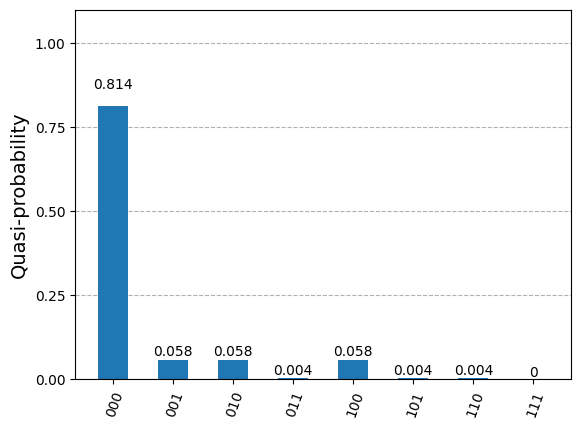

In [66]:
# fig_cons_low_noise = plot_histogram(dist_cons_low_noise, title=f"Noise below Threshold\nBias={arr_cons_low_noise[0]:.4f}, Entropy={arr_cons_low_noise[1]:.4f}")
fig_cons_low_noise = plot_histogram(dist_cons_low_noise)

# Set the y-axis range to go up to 1
ax = fig_cons_low_noise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_low_noise.show()

#### With Threshold noise

In [18]:
dist_cons_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm(f, noise_cons['thresh'], shots)
    
    for key, val in result.items():
        dist_cons_noise[key] += val

arr_cons_noise = calculate_bias_entropy(dist_cons_noise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_noise[0]}, Entropy : {arr_cons_noise[1]}")
for key, val in dist_cons_noise.items():
    dist_cons_noise[key] = val/(shots*runs)


Bias : 0.33630844000000004, Entropy : 1.6535097280512376


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\3291478684.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_noise.show()


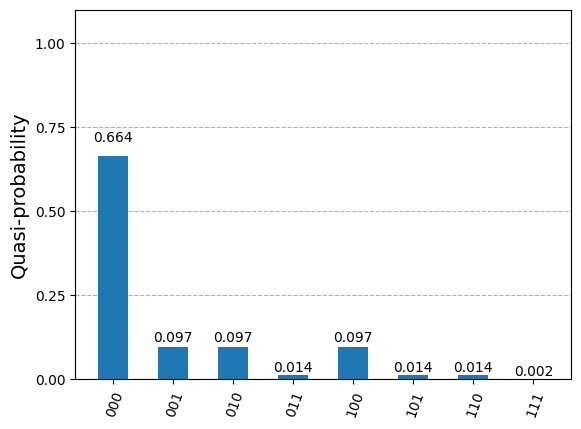

In [67]:
# fig_cons_noise = plot_histogram(dist_cons_noise, title=f"Noise at Threshold\nBias={arr_cons_noise[0]:.4f}, Entropy={arr_cons_noise[1]:.4f}")
fig_cons_noise = plot_histogram(dist_cons_noise)

# Set the y-axis range to go up to 1
ax = fig_cons_noise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_noise.show()

### Entropy vs Noise

In [27]:
runs = 1000
entropies_cons = []
biases_cons = []
noise_levels_cons = [j/100.0 for j in range(0, 51)]
for i in tqdm(noise_levels_cons, desc="Processing Noise Levels"):
    dist_cons_evn = empty_dict()
    noise_model = create_noise_model_final(i)
    for _ in range(runs):
        f = dj_function(n, balanced=0)
        result = dj_algorithm(f, noise_model, shots)[0]
        for key, val in result.items():
            dist_cons_evn[key] += val
    arr_cons_evn = calculate_bias_entropy(dist_cons_evn, unwanted['constant'])
    biases_cons.append(arr_cons_evn[0])
    entropies_cons.append(arr_cons_evn[1])
runs = 10000

Processing Noise Levels: 100%|██████████| 51/51 [23:19<00:00, 27.45s/it]


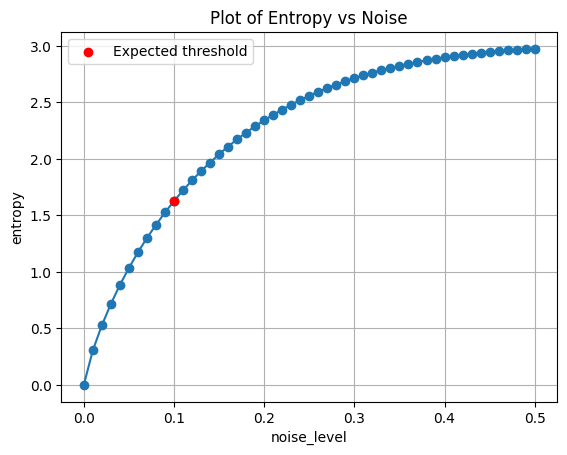

In [ ]:
plt.plot(noise_levels_cons, entropies_cons, marker='o')  # marker='o' adds points for each x-y pair
plt.xlabel('noise_level')
plt.ylabel('entropy')
plt.title('Plot of Entropy vs Noise')

# Target noise level and entropy value
# noise_level_target = round(expected_thresh_cons, 2)
noise_level_target = 0.1
entropy_value = entropies_cons[noise_levels_cons.index(noise_level_target)]  # Find corresponding entropy value
plt.scatter([noise_level_target], [entropy_value], color='red', zorder=2, label=f'at Expected threshold')
# plt.text(noise_level_target + 0.01, entropy_value-0.05, f'({noise_level_target:.4f}, {entropy_value:.4f})', 
#          color='black', fontsize=10)

plt.grid(True)
plt.legend()
plt.show()

# With Bug

In [47]:
def compile_buggy_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(int(n/2))  # bug
    qc.x(n)      #1
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)   #2
    qc.h(range(n))        #3
    # qc.x(0)  # bug
    qc.measure(range(n), range(n))
    return qc

def dj_algorithm_buggy(function: QuantumCircuit, noise, shots):
    qc = compile_buggy_circuit(function)
    simulator = AerSimulator(noise_model=noise)
    qc = qc.decompose(reps=10)
    # qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots, memory=True).result()
    # measurements = result.get_memory()
    return result.get_counts(), qc

## Count Histograms

### Balanced

#### Without noise

In [49]:
dist_bal_bug_nonoise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm_buggy(f, noise_bal['no'], shots)
    for key, val in result.items():
        dist_bal_bug_nonoise[key] += val

arr_bal_bug_nonoise = calculate_bias_entropy(dist_bal_bug_nonoise, unwanted['balanced'])
print("Bias: ", arr_bal_bug_nonoise[0], " Entropy: ",arr_bal_bug_nonoise[1])
for key, val in dist_bal_bug_nonoise.items():
    dist_bal_bug_nonoise[key] = val/(shots*runs)

Bias:  0.14421473  Entropy:  2.8073128373417315


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\2829068697.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_bug_nonoise.show()


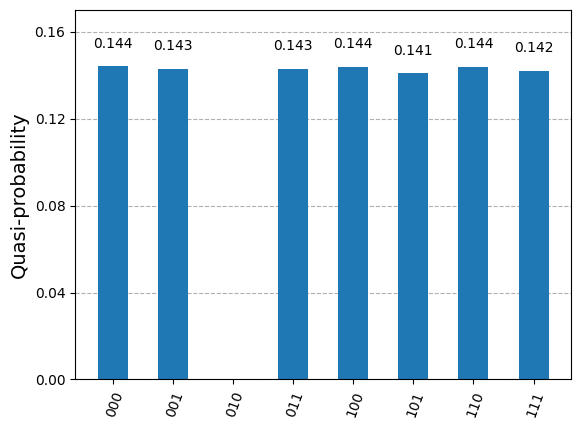

In [68]:
# fig_bal_bug_nonoise = plot_histogram(dist_bal_bug_nonoise, title=f"Noise-Free\nBias={arr_bal_bug_nonoise[0]:.4f}, Entropy={arr_bal_bug_nonoise[1]:.4f}")
fig_bal_bug_nonoise = plot_histogram(dist_bal_bug_nonoise)

# # Set the y-axis range to go up to 1
ax = fig_bal_bug_nonoise.gca()  # Get the current axes
ax.set_ylim(0, 0.17)  # Set y-axis limits

# Show the modified plot
fig_bal_bug_nonoise.show()

#### With noise below threshold

In [52]:
dist_bal_bug_low_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm_buggy(f, noise_bal['below_thresh'], shots)
    for key, val in result.items():
        dist_bal_bug_low_noise[key] += val

arr_bal_bug_low_noise = calculate_bias_entropy(dist_bal_bug_low_noise, unwanted['balanced'])
print(f"Bias : {arr_bal_bug_low_noise[0]}, Entropy : {arr_bal_bug_low_noise[1]}")
for key, val in dist_bal_bug_low_noise.items():
    dist_bal_bug_low_noise[key] = val/(shots*runs)

Bias : 0.14265534, Entropy : 2.8588268754230897


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\2286806568.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_bug_low_noise.show()


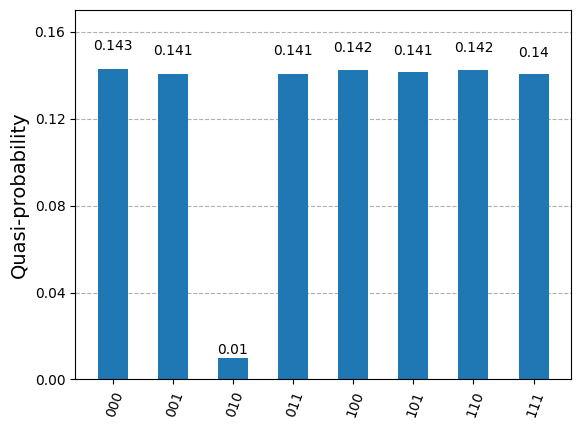

In [69]:
# fig_bal_bug_low_noise = plot_histogram(dist_bal_bug_low_noise, title=f"Noise below Threshold\nBias={arr_bal_bug_low_noise[0]:.4f}, Entropy={arr_bal_bug_low_noise[1]:.4f}")
fig_bal_bug_low_noise = plot_histogram(dist_bal_bug_low_noise)

# Set the y-axis range to go up to 1
ax = fig_bal_bug_low_noise.gca()  # Get the current axes
ax.set_ylim(0, 0.17)  # Set y-axis limits

# Show the modified plot
fig_bal_bug_low_noise.show()

#### With Threshold Noise

In [54]:
dist_bal_bug_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm_buggy(f, noise_bal['thresh'], shots)
    for key, val in result.items():
        dist_bal_bug_noise[key] += val

arr_bal_bug_noise = calculate_bias_entropy(dist_bal_bug_noise, unwanted['balanced'])
print(f"Bias : {arr_bal_bug_noise[0]}, Entropy : {arr_bal_bug_noise[1]}")
for key, val in dist_bal_bug_noise.items():
    dist_bal_bug_noise[key] = val/(shots*runs)

Bias : 0.13886694, Entropy : 2.888927930693244


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\3428589927.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_bug_noise.show()


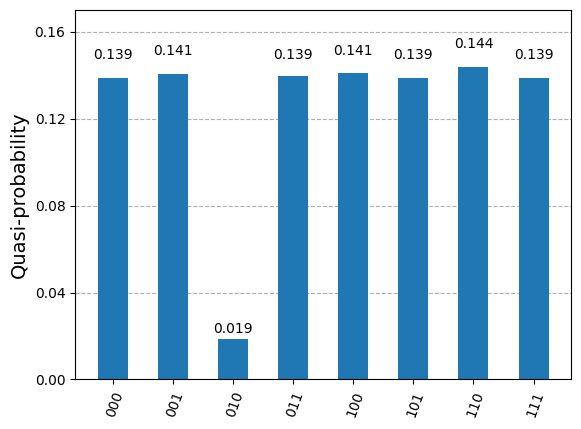

In [70]:
# fig_bal_bug_noise = plot_histogram(dist_bal_bug_noise, title=f"Noise at Threshold\nBias={arr_bal_bug_noise[0]:.4f}, Entropy={arr_bal_bug_noise[1]:.4f}")
fig_bal_bug_noise = plot_histogram(dist_bal_bug_noise)

# Set the y-axis range to go up to 1
ax = fig_bal_bug_noise.gca()  # Get the current axes
ax.set_ylim(0, 0.17)  # Set y-axis limits

# Show the modified plot
fig_bal_bug_noise.show()

### Constant

#### Without Noise

In [56]:
dist_cons_bug_nonoise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm_buggy(f, noise_cons['no'], shots)
    for key, val in result.items():
        dist_cons_bug_nonoise[key] += val

arr_cons_bug_nonoise = calculate_bias_entropy(dist_cons_bug_nonoise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_bug_nonoise[0]}, Entropy : {arr_cons_bug_nonoise[1]}")
for key, val in dist_cons_bug_nonoise.items():
    dist_cons_bug_nonoise[key] = val/(shots*runs)


Bias : 1.0, Entropy : 0.0


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\3505433129.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_bug_nonoise.show()


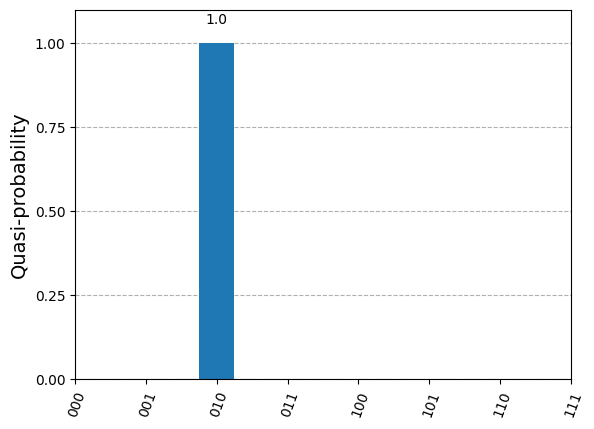

In [71]:
# fig_cons_bug_nonoise = plot_histogram(dist_cons_bug_nonoise, title=f"Noise-Free\nBias={arr_cons_bug_nonoise[0]:.4f}, Entropy={arr_cons_bug_nonoise[1]:.4f}")
fig_cons_bug_nonoise = plot_histogram(dist_cons_bug_nonoise)

# Set the y-axis range to go up to 1
ax = fig_cons_bug_nonoise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_bug_nonoise.show()

#### With noise below threshold

In [58]:
dist_cons_bug_low_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm_buggy(f, noise_cons['below_thresh'], shots)
    for key, val in result.items():
        dist_cons_bug_low_noise[key] += val

arr_cons_bug_low_noise = calculate_bias_entropy(dist_cons_bug_low_noise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_bug_low_noise[0]}, Entropy : {arr_cons_bug_low_noise[1]}")
for key, val in dist_cons_bug_low_noise.items():
    dist_cons_bug_low_noise[key] = val/(shots*runs)

Bias : 0.9163010100000001, Entropy : 1.1593995708665645


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\4057647241.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_bug_low_noise.show()


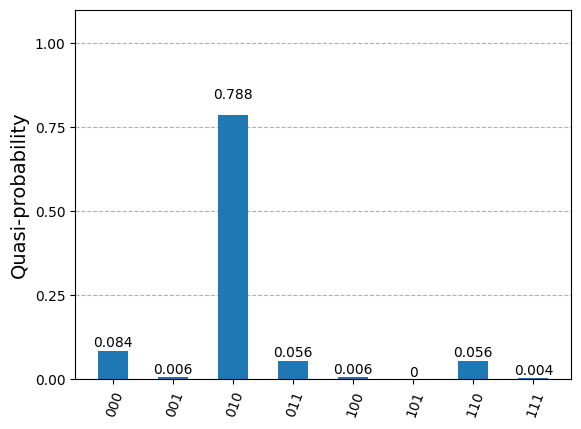

In [72]:
# fig_cons_bug_low_noise = plot_histogram(dist_cons_bug_low_noise, title=f"Noise below Threshold\nBias={arr_cons_bug_low_noise[0]:.4f}, Entropy={arr_cons_bug_low_noise[1]:.4f}")
fig_cons_bug_low_noise = plot_histogram(dist_cons_bug_low_noise)

# Set the y-axis range to go up to 1
ax = fig_cons_bug_low_noise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_bug_low_noise.show()

#### With Threshold noise

In [60]:
dist_cons_bug_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm_buggy(f, noise_cons['thresh'], shots)
    
    for key, val in result.items():
        dist_cons_bug_noise[key] += val

arr_cons_bug_noise = calculate_bias_entropy(dist_cons_bug_noise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_bug_noise[0]}, Entropy : {arr_cons_bug_noise[1]}")
for key, val in dist_cons_bug_noise.items():
    dist_cons_bug_noise[key] = val/(shots*runs)


Bias : 0.8639752299999999, Entropy : 1.7798772621160779


C:\Users\devra\AppData\Local\Temp\ipykernel_59116\62796838.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_bug_noise.show()


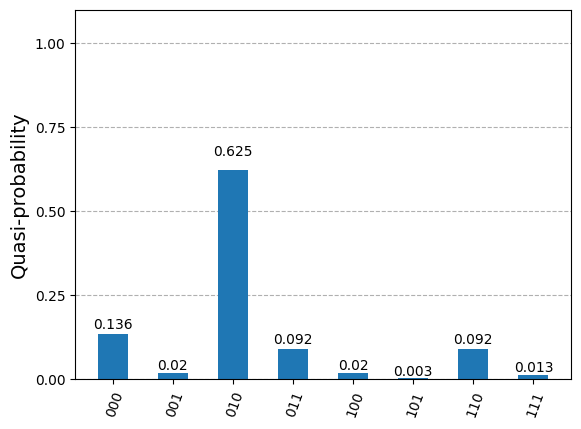

In [73]:
# fig_cons_bug_noise = plot_histogram(dist_cons_bug_noise, title=f"Noise at Threshold\nBias={arr_cons_bug_noise[0]:.4f}, Entropy={arr_cons_bug_noise[1]:.4f}")
fig_cons_bug_noise = plot_histogram(dist_cons_bug_noise)

# Set the y-axis range to go up to 1
ax = fig_cons_bug_noise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_bug_noise.show()